In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values (0-1 range)
X_train = X_train / 255.0
X_test = X_test / 255.0


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
def extract_hog_features(images):
    hog_features = []
    for img in images:
        img_gray = color.rgb2gray(img) if len(img.shape) == 3 else img
        features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)
        hog_features.append(features)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)
X_test_hog = extract_hog_features(X_test)


In [ ]:
def extract_lbp_features(images, radius=1, n_points=8):
    lbp_features = []
    for img in images:
        img_gray = color.rgb2gray(img) if len(img.shape) == 3 else img
        lbp = local_binary_pattern(img_gray, P=n_points, R=radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        lbp_features.append(lbp_hist / np.sum(lbp_hist))  # Normalize histogram
    return np.array(lbp_features)

X_train_lbp = extract_lbp_features(X_train)
X_test_lbp = extract_lbp_features(X_test)


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [ ]:
# Reduce dataset size for efficiency
subset_size = 5000
X_train_subset = X_train[:subset_size]
y_train_subset = y_train[:subset_size]
X_test_subset = X_test[:1000]

# Image preprocessing function
IMG_SIZE = 128

def preprocess_images(images, img_size=IMG_SIZE, preprocess_func=None):
    processed_images = []
    for img in images:
        img_resized = cv2.resize(img, (img_size, img_size))
        img_rgb = np.stack([img_resized] * 3, axis=-1)  # Convert grayscale to 3-channel
        processed_images.append(img_rgb)
    processed_images = np.array(processed_images, dtype="float16")
    return preprocess_func(processed_images) if preprocess_func else processed_images


In [ ]:
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
resnet_model = Model(inputs=resnet_model.input, outputs=resnet_model.output)

X_train_resnet = preprocess_images(X_train_subset, preprocess_func=resnet_preprocess)
X_test_resnet = preprocess_images(X_test_subset, preprocess_func=resnet_preprocess)

X_train_resnet_features = resnet_model.predict(X_train_resnet, batch_size=32, verbose=1)
X_test_resnet_features = resnet_model.predict(X_test_resnet, batch_size=32, verbose=1)

X_train_resnet_features = X_train_resnet_features.reshape(X_train_resnet_features.shape[0], -1)
X_test_resnet_features = X_test_resnet_features.reshape(X_test_resnet_features.shape[0], -1)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [ ]:
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
vgg_model = Model(inputs=vgg_model.input, outputs=vgg_model.output)

X_train_vgg = preprocess_images(X_train_subset, preprocess_func=vgg_preprocess)
X_test_vgg = preprocess_images(X_test_subset, preprocess_func=vgg_preprocess)

X_train_vgg_features = vgg_model.predict(X_train_vgg, batch_size=32, verbose=1)
X_test_vgg_features = vgg_model.predict(X_test_vgg, batch_size=32, verbose=1)

X_train_vgg_features = X_train_vgg_features.reshape(X_train_vgg_features.shape[0], -1)
X_test_vgg_features = X_test_vgg_features.reshape(X_test_vgg_features.shape[0], -1)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


In [ ]:
mobilenet_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
mobilenet_model = Model(inputs=mobilenet_model.input, outputs=mobilenet_model.output)

X_train_mobilenet = preprocess_images(X_train_subset, preprocess_func=mobilenet_preprocess)
X_test_mobilenet = preprocess_images(X_test_subset, preprocess_func=mobilenet_preprocess)

X_train_mobilenet_features = mobilenet_model.predict(X_train_mobilenet, batch_size=32, verbose=1)
X_test_mobilenet_features = mobilenet_model.predict(X_test_mobilenet, batch_size=32, verbose=1)

X_train_mobilenet_features = X_train_mobilenet_features.reshape(X_train_mobilenet_features.shape[0], -1)
X_test_mobilenet_features = X_test_mobilenet_features.reshape(X_test_mobilenet_features.shape[0], -1)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
def train_and_evaluate_lr(X_train, X_test, y_train, y_test, model_name):
    clf = LogisticRegression(max_iter=500)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred, average="weighted") * 100
    recall = recall_score(y_test, y_pred, average="weighted") * 100
    f1 = f1_score(y_test, y_pred, average="weighted") * 100

    print(f"\n{model_name} - Logistic Regression Results:")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}%")
    print(f"Recall: {recall:.2f}%")
    print(f"F1 Score: {f1:.2f}%")

    return accuracy
lbp_acc = train_and_evaluate_lr(X_train_lbp, X_test_lbp, y_train, y_test, "LBP")
hog_acc = train_and_evaluate_lr(X_train_hog, X_test_hog, y_train, y_test, "HOG")
resnet_acc = train_and_evaluate_lr(X_train_resnet_features, X_test_resnet_features, y_train_subset, y_test[:1000], "ResNet50")
vgg_acc = train_and_evaluate_lr(X_train_vgg_features, X_test_vgg_features, y_train_subset, y_test[:1000], "VGG16")
mobilenet_acc = train_and_evaluate_lr(X_train_mobilenet_features, X_test_mobilenet_features, y_train_subset, y_test[:1000], "MobileNetV2")



LBP - Logistic Regression Results:
Accuracy: 33.20%
Precision: 30.54%
Recall: 33.20%
F1 Score: 28.07%

HOG - Logistic Regression Results:
Accuracy: 94.75%
Precision: 94.75%
Recall: 94.75%
F1 Score: 94.74%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



ResNet50 - Logistic Regression Results:
Accuracy: 97.00%
Precision: 97.01%
Recall: 97.00%
F1 Score: 96.99%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



VGG16 - Logistic Regression Results:
Accuracy: 92.80%
Precision: 92.82%
Recall: 92.80%
F1 Score: 92.78%

MobileNetV2 - Logistic Regression Results:
Accuracy: 96.60%
Precision: 96.60%
Recall: 96.60%
F1 Score: 96.59%


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


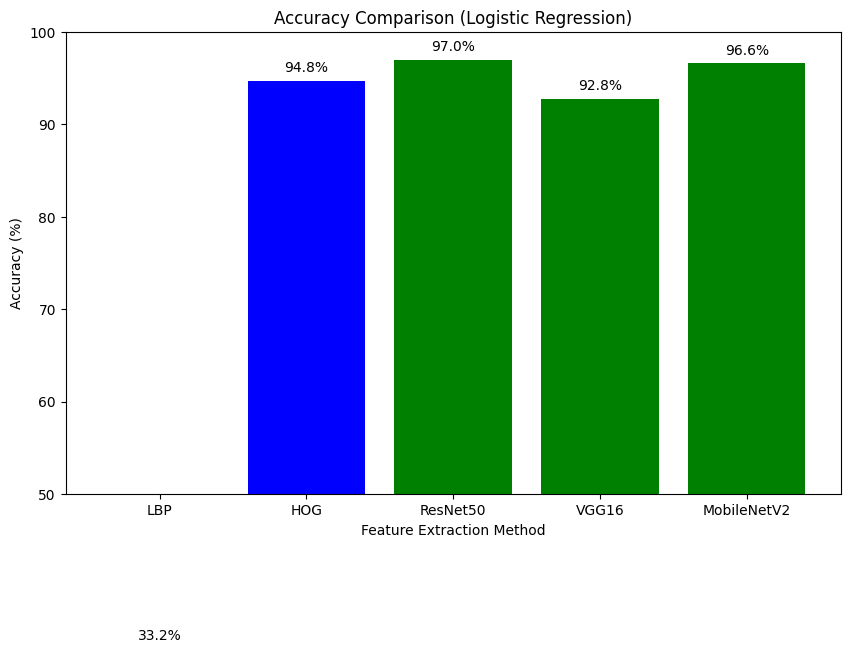

In [ ]:
accuracies_lr = {
    "LBP": lbp_acc,
    "HOG": hog_acc,
    "ResNet50": resnet_acc,
    "VGG16": vgg_acc,
    "MobileNetV2": mobilenet_acc
}

plt.figure(figsize=(10, 6))
plt.bar(accuracies_lr.keys(), accuracies_lr.values(), color=["blue", "blue", "green", "green", "green"])
plt.xlabel("Feature Extraction Method")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison (Logistic Regression)")
plt.ylim(50, 100)

for i, acc in enumerate(accuracies_lr.values()):
    plt.text(i, acc + 1, f"{acc:.1f}%", ha='center')

plt.show()
